In [36]:
# Imports
import sys, os
from Bio import Entrez
import json
from ete3 import NCBITaxa
import pandas as pd
from ete3 import Tree


In [37]:
# Declares
CSV_FILE = "../data/TP53_orthologs.csv"
#CSV_FILE = sys.argv[1]

DATA_DICT = {}

# The following looks up NCBI Taxon ID from Accession IDs
# Then uses that Taxon ID to get the complete taxnomic lineage of of that species.
Entrez.email = "aglucaci@gmail.com"


In [38]:
TREE_FILE = "../results/TP53/TP53_codons.fasta.treefile"

#TREE_FILE = sys.argv[2]

# Read file, get newick
with open(TREE_FILE, "r") as fh:
    TREE_NEWICK = fh.read()
#end with

In [40]:
TREE_NEWICK

'(NM_000546_6_Homo_sapiens_tumor_protein_p53_TP53_transcript_variant_1_mRNA_1:0.0000012619,(((((((((((((((((((((NM_011640_3_Mus_musculus_transformation_related_protein_53_Trp53_transcript_variant_1_mRNA_1:0.0159034428,XM_021177210_2_PREDICTED_Mus_caroli_tumor_protein_p53_Tp53_transcript_variant_X1_mRNA_1:0.0148652771):0.0242551838,XM_021212574_2_PREDICTED_Mus_pahari_tumor_protein_p53_Tp53_transcript_variant_X1_mRNA_1:0.0493465144):0.0297987206,XM_031351448_1_PREDICTED_Mastomys_coucha_tumor_protein_p53_Tp53_transcript_variant_X1_mRNA_1:0.0790784668):0.0277010752,(XM_028780049_1_PREDICTED_Grammomys_surdaster_tumor_protein_p53_Tp53_transcript_variant_X1_mRNA_1:0.0590862653,XM_034505539_1_PREDICTED_Arvicanthis_niloticus_tumor_protein_p53_Tp53_transcript_variant_X1_mRNA_1:0.0432057471):0.0230561869):0.0153716771,(NM_030989_3_Rattus_norvegicus_tumor_protein_p53_Tp53_mRNA_1:0.0063160139,XM_032912336_1_PREDICTED_Rattus_rattus_tumor_protein_p53_Tp53_transcript_variant_X1_mRNA_1:0.0069030239):0.

In [42]:
df = pd.read_csv(CSV_FILE)
df.index += 1
df

,Gene ID,Gene symbol,Description,Scientific name,Common name,RefSeq Transcript accessions,RefSeq Protein accessions,SPARCLE ID,Curation Status,RefseqSelect,Default sequence
1,7157,TP53,tumor protein p53,Homo sapiens,human,NM_000546.6,NP_000537.3,NaN,curated,RefseqSelect,default-seq
2,22059,Trp53,transformation related protein 53,Mus musculus,house mouse,NM_011640.3,NP_035770.2,NaN,curated,RefseqSelect,default-seq
3,24842,Tp53,tumor protein p53,Rattus norvegicus,Norway rat,NM_030989.3,NP_112251.2,NaN,curated,NaN,default-seq
4,30590,tp53,tumor protein p53,Danio rerio,zebrafish,NM_001271820.1,NP_001258749.1,10170140.0,curated,NaN,default-seq
5,281542,TP53,tumor protein p53,Bos taurus,cattle,NM_174201.2,NP_776626.1,NaN,curated,NaN,default-seq
...,...,...,...,...,...,...,...,...,...,...,...
265,121015982,TP53,tumor protein p53,Puma yagouaroundi,jaguarundi,XM_040453335.1,XP_040309269.1,NaN,model,NaN,default-seq
266,121169772,TP53,tumor protein p53,Ochotona curzoniae,black-lipped pika,XM_041000460.1,XP_040856394.1,NaN,model,NaN,default-seq
267,121456449,Tp53,tumor protein p53,Microtus oregoni,creeping vole,XM_041664596.1,XP_041520530.1,NaN,model,NaN,default-seq
268,121468489,TP53,tumor protein p53,Taeniopygia guttata,zebra finch,XM_041712170.1,XP_041568104.1,NaN,model,NaN,default-seq


In [43]:
transcript_accessions = df['RefSeq Transcript accessions'].tolist()

#len(transcript_accessions)

In [50]:
# Helper function
def match_transcript_to_tree(TREE_NEWICK, accession):
    t = Tree(TREE_NEWICK, format=1)
    
    # uncomment to debug
    #print("# in 'match_transcript_to_tree'", accession)
    
    for leafname in t.get_leaf_names():
        if accession in leafname:
            # uncomment to debug
            #print("# Returning:", leafname)
            return leafname
        #end if
    #end for
#end match
    

In [57]:
def main(transcript_accessions):
    #DATA_DICT = {}
    global DATA_DICT, TREE_NEWICK
    count = 1
    for ACCESSION in transcript_accessions:
        #print("# Checking ACCESION:", ACCESSION)
        skip = False
        for i in DATA_DICT.keys():
            if ACCESSION == DATA_DICT[i]["ACCESSION"]:
                skip = True
                break
            #end if
        #end for
        if skip == True: 
            count += 1
            continue
        #end if
        
        try:
            handle = Entrez.esummary(db="nucleotide", id=ACCESSION, rettype="gb", retmode="text", retmax=1)
            records = Entrez.parse(handle)
        except Exception as e:
            print("# Error, sleeping", e)
            time.sleep(5)
            handle = Entrez.esummary(db="nucleotide", id=ACCESSION, rettype="gb", retmode="text", retmax=1)
            records = Entrez.parse(handle)
        #end try
        
        try:
            for record in records:
                TAXON_ID = record["TaxId"]
                
                print("#", count, "Processing transcript accession:", str(ACCESSION), "with NCBI Taxon ID:", str(TAXON_ID))
                ncbi = NCBITaxa()
                
                lineage = ncbi.get_lineage(TAXON_ID)
                # uncomment to debug
                #print(lineage) # returns a list of taxon id's
                
                names = ncbi.get_taxid_translator(lineage)
                # uncomment to debug
                #print(names) # translates the taxon id's into clade names
                
                # uncomment to debug
                #print("# ACCESSION:", ACCESSION)
                leafname = ""
                leafname = match_transcript_to_tree(TREE_NEWICK, ACCESSION.replace(".", "_"))
                
                # uncomment to debug
                #print(leafname)
                
                DATA_DICT[str(count)] = {"ACCESSION": ACCESSION, "TAXON_ID": TAXON_ID, 
                                         "LINEAGE": [names[taxid] for taxid in lineage], 
                                         "TITLE":record["Title"], "LEAFNAME": leafname}
                count += 1
            #end inner for
            handle.close
        except Exception as e:
            print("# Error (main):", ACCESSION, e, "\n")
            #print(names)
            #print(e)
            #main(TREE_NEWICK) # Recursive.
            #break
        #end try
        
    #end outer for
    
    #return DATA_DICT
#end method



In [58]:
main(transcript_accessions)

# 132 Processing transcript accession: XM_017531594.2 with NCBI Taxon ID: 2715852
# Error (main): XM_017531594.2 2715852 taxid not found
# 132 Processing transcript accession: XM_017671764.2 with NCBI Taxon ID: 9974
# 133 Processing transcript accession: XM_017850544.1 with NCBI Taxon ID: 61621
# 134 Processing transcript accession: XM_018575949.1 with NCBI Taxon ID: 125878
# 135 Processing transcript accession: XM_018671426.1 with NCBI Taxon ID: 8187
# 136 Processing transcript accession: XM_018731382.2 with NCBI Taxon ID: 113540
# 137 Processing transcript accession: XM_019097598.1 with NCBI Taxon ID: 7962
# 138 Processing transcript accession: XM_019413568.1 with NCBI Taxon ID: 9691
# 139 Processing transcript accession: XM_019664961.1 with NCBI Taxon ID: 186990
# 140 Processing transcript accession: XM_019982111.1 with NCBI Taxon ID: 9915
# 141 Processing transcript accession: XM_020095710.1 with NCBI Taxon ID: 8255
# 142 Processing transcript accession: XM_020151705.1 with NCBI Ta

# 233 Processing transcript accession: XM_032912336.1 with NCBI Taxon ID: 10117
# 234 Processing transcript accession: XM_033084255.1 with NCBI Taxon ID: 91951
# 235 Processing transcript accession: XM_033091194.1 with NCBI Taxon ID: 59479
# 236 Processing transcript accession: XM_033184717.1 with NCBI Taxon ID: 54180
# 237 Processing transcript accession: XM_033925416.1 with NCBI Taxon ID: 260995
# 238 Processing transcript accession: XM_034073521.1 with NCBI Taxon ID: 13146
# 239 Processing transcript accession: XM_034505539.1 with NCBI Taxon ID: 61156
# 240 Processing transcript accession: XM_034989514.1 with NCBI Taxon ID: 9715
# 241 Processing transcript accession: XM_035135727.1 with NCBI Taxon ID: 8524
# 242 Processing transcript accession: XM_036077514.1 with NCBI Taxon ID: 9711
# 243 Processing transcript accession: XM_036197270.1 with NCBI Taxon ID: 38674
# 244 Processing transcript accession: XM_036269156.1 with NCBI Taxon ID: 27622
# 245 Processing transcript accession: XM_

In [59]:
# Check for errors here
print(len(transcript_accessions)) # Total
print(len(DATA_DICT.keys())) # What we have identified
# They need to match

269
268


In [60]:
df2 = pd.DataFrame.from_dict(DATA_DICT, orient="index")
#df2

In [65]:
df2["LINEAGE"].to_list()

[['root',
  'cellular organisms',
  'Eukaryota',
  'Opisthokonta',
  'Metazoa',
  'Eumetazoa',
  'Bilateria',
  'Deuterostomia',
  'Chordata',
  'Craniata',
  'Vertebrata',
  'Gnathostomata',
  'Teleostomi',
  'Euteleostomi',
  'Sarcopterygii',
  'Dipnotetrapodomorpha',
  'Tetrapoda',
  'Amniota',
  'Mammalia',
  'Theria',
  'Eutheria',
  'Boreoeutheria',
  'Euarchontoglires',
  'Primates',
  'Haplorrhini',
  'Simiiformes',
  'Catarrhini',
  'Hominoidea',
  'Hominidae',
  'Homininae',
  'Homo',
  'Homo sapiens'],
 ['root',
  'cellular organisms',
  'Eukaryota',
  'Opisthokonta',
  'Metazoa',
  'Eumetazoa',
  'Bilateria',
  'Deuterostomia',
  'Chordata',
  'Craniata',
  'Vertebrata',
  'Gnathostomata',
  'Teleostomi',
  'Euteleostomi',
  'Sarcopterygii',
  'Dipnotetrapodomorpha',
  'Tetrapoda',
  'Amniota',
  'Mammalia',
  'Theria',
  'Eutheria',
  'Boreoeutheria',
  'Euarchontoglires',
  'Glires',
  'Rodentia',
  'Myomorpha',
  'Muroidea',
  'Muridae',
  'Murinae',
  'Mus',
  'Mus',
  

<AxesSubplot:ylabel='LINEAGE'>

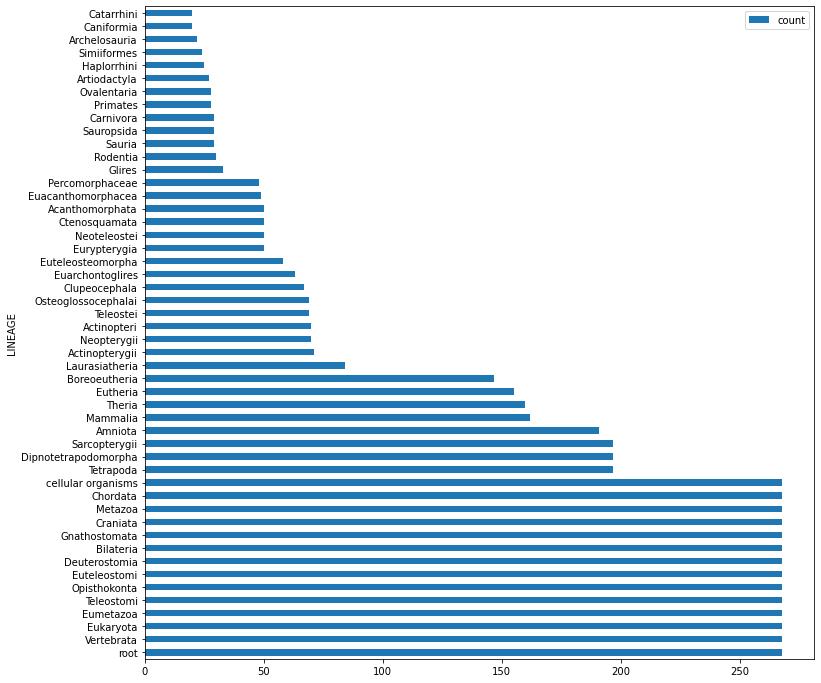

In [98]:
# use explode to expand the lists into separate rows
dfe = df2.LINEAGE.explode().to_frame().reset_index(drop=True)

## groupby the values in the column, get the count and sort
#dfg = dfe.groupby('LINEAGE').count() \
#                               .reset_index(name='count') \
#                               .sort_values(['count'], ascending=False) #

#display(dfg)
#dfg = dfe.groupby('LINEAGE').count().reset_index().sort_values(['count'], ascending=False) 
#dfg 

# plot the dataframe
#dfg.plot.bar(x='LINEAGE')

dfe

dfg = dfe.groupby('LINEAGE').LINEAGE.count() \
                               .reset_index(name='count') \
                               .sort_values(['count'], ascending=False) \
                               .head(50).reset_index(drop=True)

dfg.plot.barh(x='LINEAGE', figsize=(12, 12))


In [99]:
lineages = df2['LINEAGE'].tolist()
for i in range(len(lineages[0])):
    to_add = []
    for species in lineages:
        to_add.append(species[i])
    #end inner for
    df2["Annotation"] = to_add
    a = df2["Annotation"].nunique()
    if a > 5: break
    print(i, df2["Annotation"].nunique())
#end outer for



0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 2
15 3
16 3
17 5


<AxesSubplot:ylabel='Annotation'>

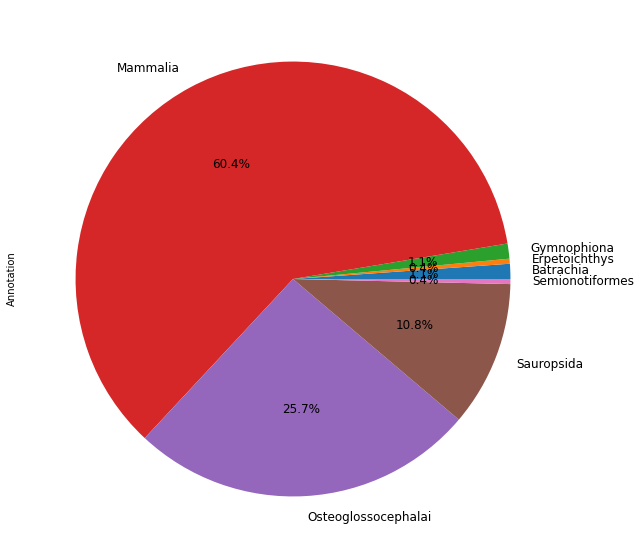

In [118]:
df2.groupby('Annotation').Annotation.count().plot.pie(figsize=(10, 10), autopct='%1.1f%%', fontsize=12)

array([<AxesSubplot:ylabel='Annotation'>], dtype=object)

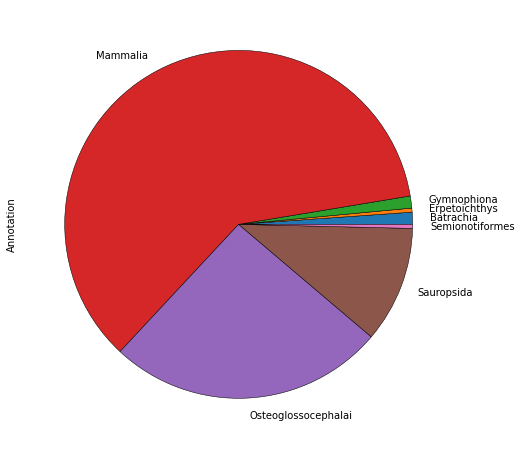

In [120]:
df2.groupby('Annotation').Annotation.count().plot.pie(figsize=(8, 8), subplots=True, wedgeprops={"edgecolor":"0",'linewidth': 0.5})

In [104]:
for item in set(df2["Annotation"].to_list()):
    #print(item)
    df3 = df2[df2["Annotation"] == item]
    print(df3)
    df3 = df3.dropna()
    
    #print(df3["LEAFNAME"].to_list())
    df3.to_csv(item + ".csv", index=True)
    
    print("# Saving to:", item + ".txt" )
    with open(item + ".txt", "w") as fh:
        fh.write("\n".join(df3["LEAFNAME"].to_list()))
        #for row in df3["LEAFNAME"].to_list():
        #    fh.write(row)

          ACCESSION  TAXON_ID  \
6       NM_205264.1      9031   
52   XM_005279339.2      8478   
56   XM_014261886.1    181119   
64   XM_025195179.1     38654   
67   XM_006112136.3     13735   
71   XM_006261004.3      8496   
80   XM_037887251.1      8469   
84   XM_007433283.3    176946   
100  XM_010571169.1     52644   
120  XM_014893382.1      9172   
125  XM_015423926.1    146911   
146  XM_020809612.1    103695   
152  XM_031507637.1    299123   
164  XM_024218614.3   2587831   
180  XM_026722699.1      8673   
194  XM_028752002.1     64176   
207  XM_030006774.1    223781   
215  XM_030474375.1   2489341   
216  XM_030548110.1   1825980   
220  XM_030970056.1     87175   
231  XM_032794536.1    106734   
234  XM_033084255.1     91951   
238  XM_034073521.1     13146   
241  XM_035135727.1      8524   
254  XM_038171817.1      8839   
256  XM_038386130.1     27794   
259  XM_039337929.1     88082   
260  XM_039500024.1    260615   
267  XM_041712170.1     59729   

         

In [103]:
df3["Annotation"]

4      Osteoglossocephalai
16     Osteoglossocephalai
19     Osteoglossocephalai
20     Osteoglossocephalai
28     Osteoglossocephalai
              ...         
218    Osteoglossocephalai
221    Osteoglossocephalai
223    Osteoglossocephalai
228    Osteoglossocephalai
229    Osteoglossocephalai
Name: Annotation, Length: 69, dtype: object

In [ ]:
# There may be errors above, some LEAFNAMEs do not populate. Check the search for subroutine to make sure it works.